In [1]:
import numpy as np
import pandas as pd
import os

from cell_metric import compute_cell_metric
from model_functions import psix_score
from tpm_to_mrna import tpm2mrna
import anndata
# from anndata import AnnData
from smartseq_tools import *


class Psix:
    
    def __init__(
        self,
        adata = anndata.AnnData(),
        reads_file = ''
    ):
        self.adata = adata
        
        if os.path.isfile(reads_file):
            self.adata = anndata.read_csv(reads_file, delimiter='\t', first_column_names=True).T
            
    def compute_psix_scores(self):
        self.exon_score_array = [psix_score(self.adata.uns['psi'][exon], 
                                       self.adata.uns['mrna_per_event'][exon], 
                                       self.adata.uns['cell_metric'], 
                                       capture_efficiency = 0.1, 
                                       randomize = False,  
                                       min_probability = 0.01,
                                       seed=0
                                    ) for exon in tqdm(self.adata.uns['psi'].columns)]
            
    def get_cell_metric(self, latent='latent', n_neighbors = 100, weight_metric=True):
        
        if latent in self.adata.obsm:
            latent = self.adata.obsm[latent]
            
        else:
            try:
                latent = pd.read_csv(latent, sep='\t', index_col=0)
                self.adata.obsm['latent'] = latent
            except:
                raise Exception('Latent space "' + latent +'" does not exist.')
                
        self.adata.uns['cell_metric'] = compute_cell_metric(latent, 
                                                       n_neighbors = n_neighbors, 
                                                       weight_metric = weight_metric
                                                      )        
        
    def process_smartseq(
        self,
        exon_sj_file,
        constitutive_sj_file,
        tpm_file,
        minJR = 5,
        minCell=20,
        drop_duplicates = False,
        min_psi = 0.05,
        min_observed = 0.1
    ):
        
        print('Obtaining psi tables...')
            
        psi, reads = get_psi_table(exon_sj_file, minJR, minCell, drop_duplicates)
        
        alt_exons = psi.index[np.abs(0.5 - psi.mean(axis=1)) <= (0.5-min_psi)]
        obs_exons = psi.index[psi.isna().mean(axis=1) < 1-min_observed]
        selected_exons = alt_exons & obs_exons
        
        psi = psi.loc[selected_exons]
        reads = reads.loc[selected_exons]
        
        print('Reading TPM and transforming to mRNA counts...')
        
        mrna = tpm2mrna(tpm_file)
        mrna_per_event = get_mrna_per_event(mrna, psi, reads, constitutive_sj_file)
        
        self.adata.uns['psi'] = psi.T
        self.adata.uns['mrna_per_event'] = mrna_per_event.T
        
        print('Successfully processed smart-seq data')



In [14]:
se_exons = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/skipped_exons_psi.tab',
                      sep='\t', index_col=0)

mrna_event = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/mrna_per_event.tab',
                        sep='\t', index_col=0)


star_counts = pd.read_csv('~/data_sc_regulation/tiklova_extended/star_counts.tab.gz', sep='\t', index_col=0)

# sj_counts = pd.read_csv('../data/prueba_tiklova_SJ/SE_counts.tab', sep='\t', index_col=0)

# constitutive_introns = pd.read_csv('../data/prueba_tiklova_SJ/constitutive_introns.tab', sep='\t', index_col=0)

tpm = pd.read_csv('~/data_sc_regulation/tiklova_extended/rsem_gene_tpm.tab.gz', sep='\t', index_col=0)

In [18]:
se_exons

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
AF529169_nmdSE_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AI413582_1,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AI480526_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AI597479_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0
AI987944_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Zzz3_11,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Zzz3_12,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Zzz3_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
discard = ['EGFP'] + [x for x in star_counts.index if x[:5]=='ERCC-']
good_genes = [x for x in star_counts.index if x not in discard]
star_counts = star_counts.loc[good_genes, se_exons.columns]
tpm = tpm[se_exons.columns]
# sj_counts = sj_counts[se_exons.columns]
# constitutive_introns = constitutive_introns[se_exons.columns]

In [20]:
# star_counts.to_csv('../data/mouse_brain_development/star_counts.tab.gz', sep='\t', index=True, header=True)
# constitutive_introns.to_csv('../data/mouse_brain_development/constitutive_introns.gz', sep='\t', index=True, header=True)
tpm.to_csv('../data/mouse_brain_development/tpm.tab.gz', sep='\t', index=True, header=True)
# sj_counts.to_csv('../data/mouse_brain_development/sj_counts.tab.gz', sep='\t', index=True, header=True)

In [21]:
tpm.shape

(48102, 1197)

In [2]:
psix_object = Psix(reads_file='../data/mouse_brain_development/star_counts.tab.gz')

In [30]:
psix_object.process_smartseq(
        '../data/mouse_brain_development/sj_counts.tab.gz',
        '../data/mouse_brain_development/constitutive_introns.gz',
        '../data/mouse_brain_development/tpm.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.1)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1197/1197 [00:51<00:00, 23.15it/s]


Successfully processed smart-seq data


In [4]:
psix_object.get_cell_metric(latent='/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/rd_pc2.tab', 
                            n_neighbors = 100, weight_metric=True)

100%|██████████| 1197/1197 [00:24<00:00, 49.42it/s]


In [5]:
psix_object.compute_psix_scores()

 12%|█▏        | 236/2019 [00:28<02:49, 10.55it/s]/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:53: RuntimeWarning: overflow encountered in double_scalars
  return comb_1*comb_2*comb_3
/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:53: RuntimeWarning: invalid value encountered in double_scalars
  return comb_1*comb_2*comb_3
 24%|██▍       | 489/2019 [01:01<02:14, 11.41it/s]/mnt/lareaulab/cfbuenabadn/psix/psix/model_functions.py:153: RuntimeWarning: invalid value encountered in true_divide
  )/np.array(cell_metric.loc[cell_list, cell_list].sum(axis=1)))
100%|██████████| 2019/2019 [04:05<00:00,  8.22it/s]


In [6]:
tiklova_psix = pd.read_csv('~/analysis_psix/mouse_brain_development/psix/pc2.scores.txt', sep='\t', index_col=0)

In [12]:
df = pd.DataFrame()
df['psix'] = psix_object.exon_score_array
df.index = psix_object.adata.uns['psi'].columns

In [19]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

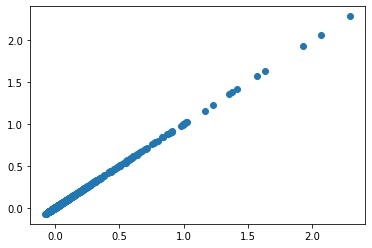

In [18]:
plt.scatter(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

In [20]:
pearsonr(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

(0.9999773959730991, 0.0)

In [21]:
spearmanr(df.psix.loc[df.index & tiklova_psix.index], tiklova_psix.loc[df.index & tiklova_psix.index].L_score)

SpearmanrResult(correlation=0.99956585186157, pvalue=0.0)

In [23]:
tiklova_psix.loc[[x for x in tiklova_psix.index if x not in df.index]]

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals
Nadk_4,mean_1_var_1,-0.003989,0.297702,0.429798,2.766284e-01,4.122536e-01
Ddr1_2,mean_1_var_2,-0.030336,0.821179,0.887713,7.997861e-01,8.655280e-01
Gtf2i_1,mean_1_var_2,0.008414,0.045954,0.104051,5.329131e-02,1.187703e-01
Lmbr1_10,mean_1_var_2,-0.000272,0.139860,0.248035,1.437671e-01,2.600598e-01
Polrmt_nmdSE_1,mean_1_var_2,-0.000655,0.139860,0.248035,1.493394e-01,2.671251e-01
Shtn1_1,mean_1_var_2,0.095389,0.000999,0.003769,5.282058e-13,3.977549e-12
Hnrnpf_3,mean_1_var_4,-0.017421,0.511489,0.639521,5.164353e-01,6.396719e-01
Ube2i_4,mean_1_var_4,-0.013223,0.408591,0.543695,4.313939e-01,5.641663e-01
Kctd17_nmdSE_1,mean_2_var_1,0.056709,0.000999,0.003769,2.258368e-09,1.403011e-08
Smim20_nmdSE_2,mean_2_var_1,-0.019210,0.855145,0.907650,8.286474e-01,8.851967e-01


In [33]:
psix_object.adata.uns['psi']#.shape#['Dync1i2_4']

,Actl6b_4,Aplp2_2,Aplp2_3,Atat1_4,Atp6v1h_5,Cadm1_10,Cadm1_2,Cd200_1,Celf4_2,Clta_2,...,Ttc3_19,Ttc3_2,Ttc3_23,Ttc3_6,Tusc3_3,Uqcr10_1,Wbp2_2,Wsb1_nmdSE_1,Ywhaz_2,Zcchc12_2
SRR7408400,1.000000,NaN,NaN,0.485714,0.200000,1.000000,0.000000,1.000000,1.0,1.000000,...,1.000000,NaN,1.000000,NaN,0.818182,0.000000,1.000000,1.000000,NaN,0.052632
SRR7408401,1.000000,NaN,NaN,0.655172,1.000000,1.000000,0.130435,0.666667,1.0,0.333333,...,0.333333,0.230769,1.000000,0.000000,1.000000,NaN,0.142857,0.538462,0.500000,0.363636
SRR7408404,0.833333,0.066667,0.687500,0.741935,0.142857,1.000000,0.100000,1.000000,1.0,0.920000,...,0.230769,0.739130,0.894737,0.142857,1.000000,0.000000,1.000000,0.428571,0.230769,0.666667
SRR7408413,0.523810,0.285714,0.454545,0.423729,0.090909,1.000000,0.000000,0.800000,1.0,NaN,...,0.090909,1.000000,1.000000,NaN,1.000000,0.000000,1.000000,0.333333,1.000000,NaN
SRR7408414,1.000000,0.485714,1.000000,0.521739,0.000000,1.000000,0.070866,1.000000,1.0,0.771429,...,0.111111,0.777778,0.777778,0.333333,1.000000,NaN,1.000000,0.230769,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,1.000000,0.659574,0.879699,0.384615,0.041667,0.750000,0.176471,1.000000,1.0,1.000000,...,0.000000,0.478261,0.500000,0.200000,0.829787,0.211538,0.838710,0.811321,0.500000,0.270833
SRR7410093,1.000000,1.000000,1.000000,1.000000,0.000000,0.959184,0.000000,0.857143,1.0,1.000000,...,0.000000,0.375000,0.333333,0.166667,1.000000,0.000000,0.227273,NaN,1.000000,0.565217
SRR7410094,0.428571,0.757576,1.000000,NaN,0.205479,0.294118,0.000000,1.000000,1.0,1.000000,...,0.000000,0.809524,0.714286,0.333333,0.905882,0.000000,0.560976,0.888889,1.000000,0.260274
SRR7410096,1.000000,0.818182,1.000000,0.000000,0.000000,0.454545,0.000000,1.000000,1.0,0.920000,...,0.000000,0.555556,0.384615,0.500000,0.866667,0.069767,1.000000,0.619048,1.000000,0.263158


In [17]:
df.index & tiklova_psix.index

Index(['Aamdc_10', 'Aamdc_9', 'Aamdc_nmdSE_2', 'Aasdhppt_2', 'Abat_3',
       'Abca3_4', 'Abhd10_1', 'Abhd10_2', 'Abhd14a_1', 'Abhd14a_3',
       ...
       'Zmiz1_1', 'Zmiz2_8', 'Zmym3_7', 'Zmynd11_7', 'Zmynd8_6', 'Zmynd8_8',
       'Znhit1_1', 'Zscan18_1', 'Zyx_1', 'Zyx_2'],
      dtype='object', length=1976)

In [24]:
se_exons = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/skipped_exons_psi.tab',
                      sep='\t', index_col=0)

In [25]:
mrna_events = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/mrna_per_event.tab',
                      sep='\t', index_col=0)

In [53]:
shared = psix_object.adata.uns['psi'].columns & se_exons.index
(se_exons.T.loc[psix_object.adata.uns['psi'].index, shared] - psix_object.adata.uns['psi'][shared]).abs().sum().sum()

8.796097530905378e-13

In [55]:
psix_object.adata.uns['psi']

,Aamdc_10,Aamdc_9,Aamdc_nmdSE_2,Aasdhppt_2,Abat_3,Abca3_4,Abhd10_1,Abhd10_2,Abhd14a_1,Abhd14a_3,...,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,Zyx_2,l7Rn6_1,l7Rn6_3,l7Rn6_nmdSE_1
SRR7408400,0.000000,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.428571,0.200000,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.333333
SRR7408401,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.2,0.0,NaN
SRR7408404,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.714286,0.000000,NaN,NaN,0.0,1.0,NaN,0.000000
SRR7408413,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.0,NaN,0.000000
SRR7408414,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN,...,1.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,1.000000,1.000000,0.0,1.0,0.741935,NaN,0.0,1.0,0.444444,0.230769,...,1.0,0.0,NaN,0.176471,1.000000,0.0,1.0,NaN,NaN,NaN
SRR7410093,1.000000,1.000000,NaN,1.0,1.000000,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.714286,0.0,1.0,1.0,1.0,0.000000
SRR7410094,1.000000,1.000000,0.0,1.0,1.000000,NaN,NaN,1.0,0.000000,0.000000,...,1.0,NaN,NaN,0.000000,1.000000,NaN,NaN,1.0,0.0,0.000000
SRR7410096,0.882353,0.833333,0.0,1.0,1.000000,1.0,1.0,1.0,0.000000,0.000000,...,0.0,NaN,NaN,0.000000,1.000000,NaN,NaN,1.0,0.0,NaN


In [29]:
shared = psix_object.adata.uns['mrna_per_event'].columns & se_exons.index
(mrna_events.T.loc[psix_object.adata.uns['mrna_per_event'].index, shared] - psix_object.adata.uns['mrna_per_event'][shared]).abs().mean().mean()

0.01683056281720648

In [30]:
mrna_events.T.loc[psix_object.adata.uns['mrna_per_event'].index, shared]

,AW554918_2,Aaed1_1,Aak1_2,Aak1_5,Aamdc_10,Aamdc_9,Aamdc_nmdSE_2,Aars2_2,Aasdhppt_2,Abat_3,...,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,Zyx_2,Zzz3_10,Zzz3_11,Zzz3_12
SRR7408400,0.917420,NaN,NaN,NaN,3.669681,0.917420,1.834840,NaN,NaN,NaN,...,2.752261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.228644,NaN,...,NaN,3.171483,NaN,NaN,NaN,0.528581,NaN,NaN,NaN,NaN
SRR7408404,NaN,NaN,NaN,NaN,1.617931,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.831379,4.044827,NaN,NaN,0.808965,NaN,1.213448,0.404483
SRR7408413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.183354,NaN,...,NaN,NaN,NaN,2.366708,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.199988,0.639998,1.279995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,NaN,NaN,1.492173,1.11913,2.984346,3.357389,2.238259,NaN,4.849562,11.564340,...,2.611303,3.730432,NaN,12.683470,0.373043,0.746086,0.373043,NaN,NaN,NaN
SRR7410093,NaN,NaN,NaN,NaN,5.895941,1.310209,NaN,NaN,7.206150,0.655105,...,NaN,NaN,NaN,NaN,4.585732,1.310209,1.310209,NaN,NaN,NaN
SRR7410094,NaN,0.398425,0.796850,NaN,2.390550,1.195275,0.796850,NaN,0.796850,0.398425,...,2.390550,NaN,NaN,4.781101,0.398425,NaN,NaN,NaN,0.796850,NaN
SRR7410096,NaN,1.625401,NaN,NaN,13.815908,9.752406,3.250802,3.250802,0.812700,4.063502,...,1.625401,NaN,NaN,3.250802,1.625401,NaN,NaN,NaN,NaN,NaN


In [31]:
psix_object.adata.uns['mrna_per_event'][shared]

,AW554918_2,Aaed1_1,Aak1_2,Aak1_5,Aamdc_10,Aamdc_9,Aamdc_nmdSE_2,Aars2_2,Aasdhppt_2,Abat_3,...,Zmynd11_7,Zmynd8_6,Zmynd8_8,Znhit1_1,Zscan18_1,Zyx_1,Zyx_2,Zzz3_10,Zzz3_11,Zzz3_12
SRR7408400,0.916748,NaN,NaN,NaN,3.666991,0.916748,1.833496,NaN,NaN,NaN,...,2.750243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.197112,NaN,...,NaN,3.147834,NaN,NaN,NaN,0.524639,NaN,NaN,NaN,NaN
SRR7408404,NaN,NaN,NaN,NaN,1.614259,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.824954,4.035648,NaN,NaN,0.807130,NaN,1.210694,0.403565
SRR7408413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.176053,NaN,...,NaN,NaN,NaN,2.352106,NaN,NaN,NaN,NaN,NaN,NaN
SRR7408414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.213076,0.642615,1.285230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7410092,NaN,NaN,1.479068,1.109301,2.958137,3.327904,2.218602,NaN,4.806972,11.462780,...,2.588370,3.697671,NaN,12.572081,0.369767,0.739534,0.369767,NaN,NaN,NaN
SRR7410093,NaN,NaN,NaN,NaN,5.825304,1.294512,NaN,NaN,7.119816,0.647256,...,NaN,NaN,NaN,NaN,4.530792,1.294512,1.294512,NaN,NaN,NaN
SRR7410094,NaN,0.396928,0.793856,NaN,2.381569,1.190784,0.793856,NaN,0.793856,0.396928,...,2.381569,NaN,NaN,4.763138,0.396928,NaN,NaN,NaN,0.793856,NaN
SRR7410096,NaN,1.613623,NaN,NaN,13.715795,9.681738,3.227246,3.227246,0.806811,4.034057,...,1.613623,NaN,NaN,3.227246,1.613623,NaN,NaN,NaN,NaN,NaN


In [ ]:
constitutive_sj = pd.read_csv(constitutive_sj_file, sep=',', index_col=0)
        obs_mrna = mrna.index[mrna.median(axis=1) >= 1]
        obs_junctions = [x for x in constitutive_sj.index if x.split('_')[0] in obs_mrna]
        
        mrna_per_junction = mrna.loc[[x.split('_')[0] for x in obs_junctions]]
        mrna_per_junction.index = obs_junctions
        
        reads_per_junction = (constitutive_sj.loc[obs_junctions] / mrna_per_junction).replace([np.inf, -np.inf], np.nan)
        SJ_mean = reads_per_junction.mean()
        int_exons = psi.index[np.abs(0.5 - psi.mean(axis=1)) <= 0.45] & psi.index[psi.isna().mean(axis=1) < 0.9]
        psi = psi.loc[int_exons]
        mrna_events = (reads.loc[int_exons]/(SJ_mean * (1+psi)))
        
        self.adata.uns['psi'] = psi.T
        self.adata.uns['mrna_per_event'] = mrna_events.T

In [60]:
tiklova_ci = pd.read_csv(constitutive_sj_file, sep=',', index_col=0)

tiklova_mrna = tiklova_mrna[tiklova_norm.columns]
tiklova_mrna_expressed = tiklova_mrna.loc[tiklova_mrna.median(axis=1) >= 1]

xlist = [x for x in tiklova_ci.index if x.split('_')[0] in tiklova_mrna_expressed.index]
tiklova_mrna_per_junction = tiklova_mrna_expressed.loc[[x.split('_')[0] for x in xlist]]
tiklova_mrna_per_junction.index = xlist

tiklova_ratio = (tiklova_ci.loc[tiklova_mrna_per_junction.index] / tiklova_mrna_per_junction).replace([np.inf, -np.inf], np.nan)
tiklova_SJ = pd.DataFrame()
tiklova_SJ['SJ_mean'] = tiklova_ratio[tiklova_mrna.columns].mean()
tiklova_SJ['SJ_median'] = tiklova_ratio[tiklova_mrna.columns].median()
# tiklova_SJ.to_csv()
# tiklova_ratio.to_csv()

discard = [x for x in tiklova_mrna.index if ((x[:3] in ['mt-', 'Gm0', 'Gm1', 'Gm2', 'Gm3', 'Gm4', 'Gm5', 
                                'Gm6', 'Gm7', 'Gm8', 'Gm9', 'Mir']) or (x[-3:] in ['Rik', '-ps']) or (x [-4:-1] == '-ps'))]

good_genes = [x for x in tiklova_mrna.index if x not in discard]
good_exons = [x for x in tiklova_PSI.index if x.split('_')[0] in good_genes]

tiklova_PSI = tiklova_PSI.loc[good_exons]

tiklova_exons = tiklova_PSI.index[np.abs(0.5 - tiklova_PSI.mean(axis=1)) <= 0.45] & tiklova_PSI.index[tiklova_PSI.isna().mean(axis=1) < 0.5]

tiklova_mrna_events = (tiklova_reads.loc[tiklova_PSI.index]/(tiklova_SJ.SJ_mean * (1+tiklova_PSI)))[tiklova_mrna.columns[tiklova_mrna.sum() < 10**5.5]]
#

True

In [37]:
from cell_metric import compute_cell_metric


In [85]:
os.path.isfile('')

False

In [1]:
import numpy as np
import pandas as pd
import anndata

In [7]:
data = pd.DataFrame(np.zeros((20, 10)))
data.index = ['cell_' + str(i) for i in range(1, 21)]
data.columns = ['exon_' + str(i) for i in range(1, 11)]

data_psi = pd.DataFrame(np.ones((20, 10)))
data_psi.index = ['cell_' + str(i) for i in range(1, 21)]
data_psi.columns = ['exon_' + str(i) for i in range(1, 11)]

In [38]:
cell_metric = pd.DataFrame((np.ones((20, 20))*0.5))
cell_metric.index = ['cell_' + str(i) for i in range(1, 21)]
cell_metric.columns = ['cell_' + str(i) for i in range(1, 21)]

In [25]:
adata = anndata.AnnData(data_psi)#.varm

In [84]:
adata.obs[np.median(adata.layers['mrna'], axis=1)>=0]

""
cell_1
cell_2
cell_3
cell_4
cell_5
cell_6
cell_7
cell_8
cell_9
cell_10


In [54]:
adata.layers['metric'] = cell_metric

ValueError: Value passed for key 'metric' is of incorrect shape. Values of layers must match dimensions (0, 1) of parent. Value had shape (20, 20) while it should have had (20, 10).

In [56]:
type(adata.uns['cell_metric'])

pandas.core.frame.DataFrame

In [41]:
adata.uns['cell_metric'] = cell_metric

In [51]:
'cell_metricdsd' in adata.uns

False